In [9]:
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split

In [10]:
sentiments = pd.read_csv("../data/sentiment/sentiment_days.csv")
sentiments.date = pd.to_datetime(sentiments.date, format='%Y-%m-%d')
tickers = pd.read_csv("../data/kaggle/asx-tickers.csv")
tickers.drop(['company'], axis=1, inplace=True)
stocks = pd.read_csv("../data/percent_change/relative_change.csv")
stocks.date = pd.to_datetime(stocks.date, format='%Y%m%d')
stocks.drop(['Unnamed: 0'], axis=1, inplace=True)
stocks = stocks[(stocks.date > '2005-12-31') & (stocks.date < '2017-12-31')]

In [11]:
sentiments.head(1)

,date,mode,Sum_QDAP,Sum,Mean_QDAP,Mean
0,2006-01-01,negative,-5.909524,negative,-0.060301,negative


In [12]:
stocks.head(1)

,ticker,date,close,rel_difference_close_open,rel_difference_close_close
2200632,AAC,2006-01-03,1.64,0.015244,0.051829


In [13]:
industries = stocks.merge(tickers, on='ticker')
sentiments['prior_date']=sentiments.date + datetime.timedelta(days=1)
data = industries.merge(sentiments, left_on='date', right_on='prior_date', how='inner')
data['label'] = np.where(data['rel_difference_close_open']>0, 1, 0)

In [14]:
data.head(3)

,ticker,date_x,close,rel_difference_close_open,rel_difference_close_close,industry,date_y,mode,Sum_QDAP,Sum,Mean_QDAP,Mean,prior_date,label
0,AAC,2006-01-03,1.640,0.015244,0.051829,"Food, Beverage & Tobacco",2006-01-02,neutral,-4.304762,negative,-0.031887,negative,2006-01-03,1
1,AAR,2006-01-03,0.019,-0.052632,-0.052632,Materials,2006-01-02,neutral,-4.304762,negative,-0.031887,negative,2006-01-03,0
2,AAU,2006-01-03,0.700,0.028571,0.028571,Media,2006-01-02,neutral,-4.304762,negative,-0.031887,negative,2006-01-03,1


In [18]:
industry = 'Food, Beverage & Tobacco'
groups = data.groupby('industry')
tick_dat = groups.get_group(industry)

svc = SVC(kernel='rbf')
train, test = train_test_split(tick_dat, test_size=0.2)

train_X = train[['close', 'Sum_QDAP']]
train_Y = train[['label']]
test_X = test[['close','Sum_QDAP']]
test_Y = test[['label']]

model = svc.fit(train_X, train_Y.values.ravel())
predict = model.predict(test_X)
print(model.score(test_X,test_Y))

0.6192331532807934


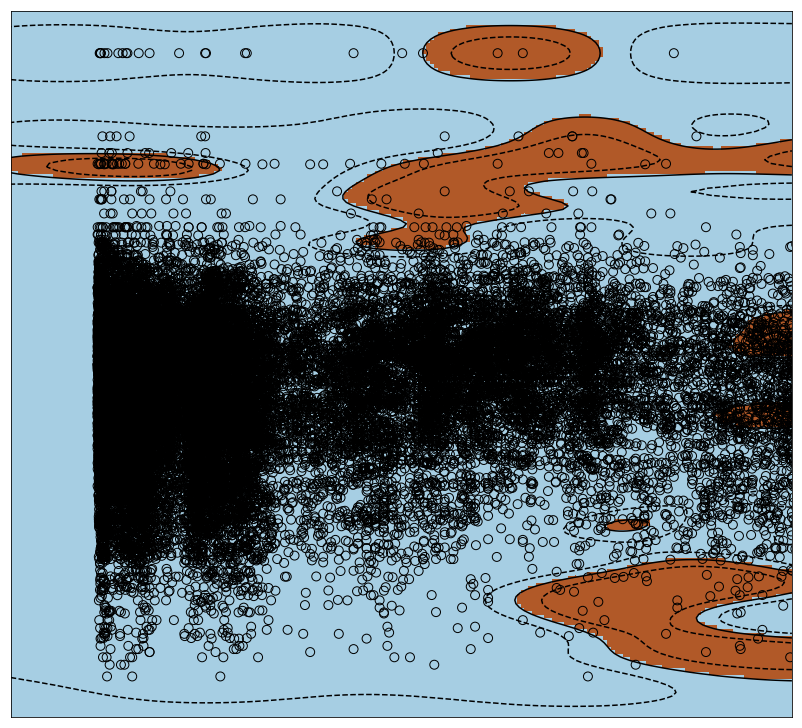

In [19]:
# http://scikit-learn.org/stable/auto_examples/svm/plot_svm_kernels.html
plt.figure(1, figsize=(14, 13))
plt.clf()
plt.scatter(model.support_vectors_[:, 0], model.support_vectors_[:, 1], s=80, facecolors='none', zorder=10, edgecolors='k')
# plt.scatter(test_X.values[:, 0], test_X.values[:, 1], c=test_Y.values, zorder=10, cmap=plt.cm.Paired, edgecolors='k')

plt.axis('tight')
x_min = -1
x_max = 8
y_min = -25
y_max = 18

XX, YY = np.mgrid[x_min:x_max:200j, y_min:y_max:200j]
Z = model.decision_function(np.c_[XX.ravel(), YY.ravel()])

# Put the result into a color plot
Z = Z.reshape(XX.shape)
plt.figure(1, figsize=(4, 3))
plt.pcolormesh(XX, YY, Z > 0, cmap=plt.cm.Paired)
plt.contour(XX, YY, Z, colors=['k', 'k', 'k'], linestyles=['--', '-', '--'],
            levels=[-.5, 0, .5])

plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)

plt.xticks(())
plt.yticks(())
plt.show()